In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path
from typing import Any, Callable, Optional

import numpy as np
from PIL import Image
from torchvision.datasets.vision import VisionDataset


class SegmentationDataset(VisionDataset):
    def __init__(self,
                 root: str,
                 image_folder: str,
                 mask_folder: str,
                 transforms: Optional[Callable] = None,
                 seed: int = None,
                 fraction: float = None,
                 subset: str = None,
                 image_color_mode: str = "rgb",
                 mask_color_mode: str = "rgb") -> None:
        
        super().__init__(root, transforms)
        image_folder_path = Path(self.root) / image_folder
        mask_folder_path = Path(self.root) / mask_folder
        if not image_folder_path.exists():
            raise OSError(f"{image_folder_path} does not exist.")
        if not mask_folder_path.exists():
            raise OSError(f"{mask_folder_path} does not exist.")

        if image_color_mode not in ["rgb", "grayscale"]:
            raise ValueError(
                f"{image_color_mode} is an invalid choice. Please enter from rgb grayscale."
            )
        if mask_color_mode not in ["rgb", "grayscale"]:
            raise ValueError(
                f"{mask_color_mode} is an invalid choice. Please enter from rgb grayscale."
            )

        self.image_color_mode = image_color_mode
        self.mask_color_mode = mask_color_mode

        if not fraction:
            self.image_names = sorted(image_folder_path.glob("*"))
            self.mask_names = sorted(mask_folder_path.glob("*"))
        else:
            if subset not in ["Train", "Test"]:
                raise (ValueError(
                    f"{subset} is not a valid input. Acceptable values are Train and Test."
                ))
            self.fraction = fraction
            self.image_list = np.array(sorted(image_folder_path.glob("*")))
            self.mask_list = np.array(sorted(mask_folder_path.glob("*")))
            if seed:
                np.random.seed(seed)
                indices = np.arange(len(self.image_list))
                np.random.shuffle(indices)
                self.image_list = self.image_list[indices]
                self.mask_list = self.mask_list[indices]
            if subset == "Train":
                self.image_names = self.image_list[:int(
                    np.ceil(len(self.image_list) * (1 - self.fraction)))]
                self.mask_names = self.mask_list[:int(
                    np.ceil(len(self.mask_list) * (1 - self.fraction)))]
            else:
                self.image_names = self.image_list[
                    int(np.ceil(len(self.image_list) * (1 - self.fraction))):]
                self.mask_names = self.mask_list[
                    int(np.ceil(len(self.mask_list) * (1 - self.fraction))):]

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, index: int) -> Any:
        image_path = self.image_names[index]
        mask_path = self.mask_names[index]
        with open(image_path, "rb") as image_file, open(mask_path,
                                                        "rb") as mask_file:
            image = Image.open(image_file)
            if self.image_color_mode == "rgb":
                image = image.convert("RGB")
            elif self.image_color_mode == "grayscale":
                image = image.convert("L")
            mask = Image.open(mask_file)
            if self.mask_color_mode == "rgb":
                mask = mask.convert("RGB")
            elif self.mask_color_mode == "grayscale":
                mask = mask.convert("L")
            sample = {"image": image, "mask": mask}
            if self.transforms:
                sample["image"] = self.transforms(sample["image"])
                sample["mask"] = self.transforms(sample["mask"])
            return sample

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader
def get_dataloader_sep_folder(data_dir: str,
                              image_folder: str = 'image',
                              mask_folder: str = 'mask',
                              batch_size: int = 4):
    
    data_transforms = transforms.Compose([transforms.Resize(256),
                 transforms.CenterCrop(224),
                 transforms.ToTensor(), 
                 transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])

    image_datasets = {
        x: SegmentationDataset(root=Path(data_dir) / x,
                               transforms=data_transforms,
                               image_folder=image_folder,
                               mask_folder=mask_folder)
        for x in ['Train', 'Test']
    }
    dataloaders = {
        x: DataLoader(image_datasets[x],
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=2)
        for x in ['Train', 'Test']
    }
    return dataloaders

In [4]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models


def createDeepLabv3(outputchannels=3):
    model = models.segmentation.fcn_resnet101(pretrained=True,
                                                    progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

In [5]:
import copy
import csv
import os
import time

import numpy as np
import torch
from tqdm import tqdm

def train_model(model, criterion, dataloaders, optimizer, metrics, bpath,
                num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Test_{m}' for m in metrics.keys()]
    with open(os.path.join(bpath, 'log2.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  
            else:
                model.eval()  

            
            for sample in tqdm(iter(dataloaders[phase])):
                inputs = sample['image'].to(device)
                #print(inputs.shape)
                masks = sample['mask'].to(device)
                #print(inputs.shape)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    #print(outputs['out'].shape)
                    loss = criterion(outputs['out'], masks)
                    y_pred = outputs['out'].data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0.1))
                        else:
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true.astype('uint8'), y_pred))

                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(phase, loss))
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        with open(os.path.join(bpath, 'log2.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)
            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)
    return model

In [6]:
import click
import torch
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from torch.utils import data

model = createDeepLabv3()
model.train()
data_directory = '/content/drive/MyDrive/comp548/proje_local/main_dir'
exp_directory = '/content/drive/MyDrive/comp548/proje_local/deneme-results'
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
metrics = {'f1_score': f1_score}
dataloaders = get_dataloader_sep_folder(data_directory, batch_size=4)
new_model = train_model(model,
                    criterion,
                    dataloaders,
                    optimizer,
                    bpath=exp_directory,
                    metrics=metrics,
                    num_epochs=10)

Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth



Epoch 1/10
----------


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]

Train Loss: 3.5048



100%|██████████| 3/3 [00:06<00:00,  2.14s/it]

Test Loss: 3.7564
{'epoch': 1, 'Train_loss': 3.5048012733459473, 'Test_loss': 3.7564265727996826, 'Train_f1_score': 0.2802459539099648, 'Test_f1_score': 0.0}
Epoch 2/10
----------



100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

Train Loss: 2.9071



100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


Test Loss: 3.7268
{'epoch': 2, 'Train_loss': 2.907099962234497, 'Test_loss': 3.7268049716949463, 'Train_f1_score': 0.4580895567944454, 'Test_f1_score': 0.23352403475686986}
Epoch 3/10
----------


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

Train Loss: 2.5764



100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Test Loss: 3.5085
{'epoch': 3, 'Train_loss': 2.576368570327759, 'Test_loss': 3.50850510597229, 'Train_f1_score': 0.5355843644980456, 'Test_f1_score': 0.46380688932574027}
Epoch 4/10
----------


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

Train Loss: 2.2520



100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Test Loss: 3.2019
{'epoch': 4, 'Train_loss': 2.2520012855529785, 'Test_loss': 3.2019429206848145, 'Train_f1_score': 0.6268675150015565, 'Test_f1_score': 0.5710270571675757}
Epoch 5/10
----------


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

Train Loss: 2.0210



100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


Test Loss: 2.8306
{'epoch': 5, 'Train_loss': 2.021040439605713, 'Test_loss': 2.830587863922119, 'Train_f1_score': 0.6543834621259085, 'Test_f1_score': 0.5966802857702909}
Epoch 6/10
----------


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

Train Loss: 1.6805



100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Test Loss: 2.1290
{'epoch': 6, 'Train_loss': 1.6805007457733154, 'Test_loss': 2.128978967666626, 'Train_f1_score': 0.6757540990057849, 'Test_f1_score': 0.6033909227827137}
Epoch 7/10
----------


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

Train Loss: 1.5487



100%|██████████| 3/3 [00:00<00:00,  3.73it/s]

Test Loss: 2.2152
{'epoch': 7, 'Train_loss': 1.5487117767333984, 'Test_loss': 2.2151999473571777, 'Train_f1_score': 0.6927687739986093, 'Test_f1_score': 0.6010538978022026}
Epoch 8/10
----------



100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

Train Loss: 1.3895



100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Test Loss: 2.0777
{'epoch': 8, 'Train_loss': 1.3895014524459839, 'Test_loss': 2.0777013301849365, 'Train_f1_score': 0.7059288632646625, 'Test_f1_score': 0.6038657461646786}
Epoch 9/10
----------


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

Train Loss: 1.2341



100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


Test Loss: 1.9951
{'epoch': 9, 'Train_loss': 1.234073281288147, 'Test_loss': 1.9951422214508057, 'Train_f1_score': 0.7112339011590468, 'Test_f1_score': 0.6061383274465819}
Epoch 10/10
----------


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]

Train Loss: 1.1620



100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Test Loss: 1.7225
{'epoch': 10, 'Train_loss': 1.1619536876678467, 'Test_loss': 1.7225009202957153, 'Train_f1_score': 0.7226509367231212, 'Test_f1_score': 0.6166535908801052}
Training complete in 1m 8s
Lowest Loss: 1.722501


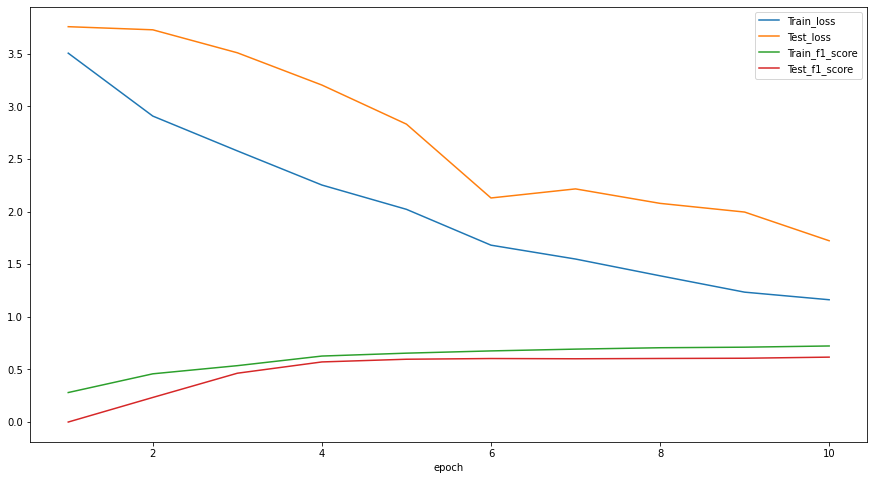

In [7]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/comp548/proje_local/deneme-results/log2.csv')
df.plot(x='epoch',figsize=(15,8));

In [8]:
new_model.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [9]:
from PIL import Image
image = Image.open('/content/drive/MyDrive/comp548/proje_local/main_dir/Test/image/TCGA-S3-AA15-DX1_id-5ea40a6addda5f839898f24a_left-57003_top-29682_bottom-29950_right-57283.png')
mask = Image.open('/content/drive/MyDrive/comp548/proje_local/main_dir/Test/mask/TCGA-S3-AA15-DX1_id-5ea40a6addda5f839898f24a_left-57003_top-29682_bottom-29950_right-57283.png')

In [10]:
trf = transforms.Compose([transforms.Resize(256),
                 transforms.CenterCrop(224),
                 transforms.ToTensor(), 
                 transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(image).unsqueeze(0)
print(inp.shape)

torch.Size([1, 3, 224, 224])


In [11]:
out = new_model(inp.cuda())['out']
print (out.shape)

torch.Size([1, 3, 224, 224])


In [12]:
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print(om.shape)
print(np.unique(om))

(224, 224)
[0 1 2]


In [13]:
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

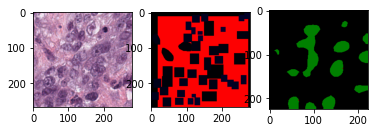

In [14]:
rgb = decode_segmap(om)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(image)
axarr[1].imshow(mask)
axarr[2].imshow(rgb)

#plt.title('Image')
#plt.imshow(image)
#plt.show()
#plt.title('Mask')
#plt.imshow(mask)
#plt.show()
#plt.title('Segmentation')
#plt.imshow(rgb)
#plt.show()

In [15]:
from PIL import Image
image2 = Image.open('/content/drive/MyDrive/comp548/proje_local/main_dir/Train/image/TCGA-A1-A0SP-DX1_id-5ea4095addda5f8398977ebc_left-11841_top-57182_bottom-57525_right-12205.png')
mask2 = Image.open('/content/drive/MyDrive/comp548/proje_local/main_dir/Train/mask/TCGA-A1-A0SP-DX1_id-5ea4095addda5f8398977ebc_left-11841_top-57182_bottom-57525_right-12205.png')


In [16]:
trf = transforms.Compose([transforms.Resize(256),
                 transforms.CenterCrop(224),
                 transforms.ToTensor(), 
                 transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp2 = trf(image2).unsqueeze(0)
print(inp2.shape)

torch.Size([1, 3, 224, 224])


In [17]:
out2 = new_model(inp2.cuda())['out']
print(out2.shape)

torch.Size([1, 3, 224, 224])


In [18]:
om2 = torch.argmax(out2.squeeze(), dim=0).detach().cpu().numpy()
print(om2.shape)
print(np.unique(om2))

(224, 224)
[0 1 2]


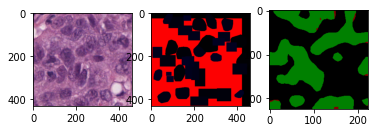

In [19]:
rgb2 = decode_segmap(om2)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(image2)
axarr[1].imshow(mask2)
axarr[2].imshow(rgb2)

#plt.title('Image')
#plt.imshow(image2)
#plt.show()
#plt.title('Mask')
#plt.imshow(mask2)
#plt.show()
#plt.title('Segmentation')
#plt.imshow(rgb2)
#plt.show()